# **Import libraries**

In [1]:
## Import commands of libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# **Load the dataset**

In [2]:
import openpyxl

# Load the Excel workbook
workbook = openpyxl.load_workbook('Sales.xlsx')

# Create an empty list to hold the DataFrames
dfs = []

# Loop through all the sheets in the workbook
for sheet in workbook:
    # Load the sheet into a DataFrame and append it to the list
    dfs.append(pd.read_excel('Sales.xlsx', sheet_name=sheet.title))

# Concatenate the DataFrames vertically
data = pd.concat(dfs, axis=0)

The code you provided loads an Excel workbook using the openpyxl library and reads each sheet into a separate pandas DataFrame using the pd.read_excel() function. The DataFrames are then concatenated vertically using pd.concat().

This code assumes that the Excel workbook named "Sales.xlsx" is located in the same directory as the Python script. If the workbook is located elsewhere, you will need to provide the full path to the workbook file.

Once you have loaded the data into a pandas DataFrame, you can perform various operations on it, such as filtering, aggregating, and visualizing the data.

Note that this code requires the openpyxl and pandas libraries to be installed. If you don't have these libraries installed, you can install them using pip:

pip install openpyxl pandas


In [3]:
data

TANGGAL    TOTAL  KUE SUS  BIKANGDOANG  DONUT COKLAT  PUDDING  RESOLES  \
0  2022-01-04  3508450      300           27            38       13       28   
1  2022-01-05  4667997      400           13            44       15       42   
2  2022-01-06  5251515      410            2            83       30       92   
3  2022-01-07  5745135      350           14            57       29       30   
4  2022-01-08  6465465      400           17            46       27       29   
..        ...      ...      ...          ...           ...      ...      ...   
26 2022-03-27  5462686      400           11            32       10       30   
27 2022-03-28  3989886      300            5            30        1       24   
28 2022-03-29  3499879      340            2            30        0       20   
29 2022-03-30  5531206      380           13            44       10       30   
30 2022-03-31  6703068      424           18            52       24       30   

    ROTI KEJU  ROTI AYAM  BLUDER  SIRAM COKLAT  APANG PARANGGI  
0           2          2      30            45              19  
1           1          1      40           110              29  
2           1          1      35            76              10  
3           3          2      44           108               7  
4           3          3      34           100              24  
..        ...        ...     ...           ...             ...  
26          1          2      36            30              15  
27          1          2      20            15               3  
28          2          2      25            19               5  
29          2          1      44            25               8  
30          2          2      52            44              10  

[86 rows x 12 columns]

In [4]:
## check dataset dimension
data.shape

(86, 12)

In [5]:
#3 check dataset columns
data.columns

Index(['TANGGAL', 'TOTAL', 'KUE SUS', 'BIKANGDOANG', 'DONUT COKLAT', 'PUDDING',
       'RESOLES', 'ROTI KEJU', 'ROTI AYAM', 'BLUDER', 'SIRAM COKLAT',
       'APANG PARANGGI'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 30
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TANGGAL         86 non-null     datetime64[ns]
 1   TOTAL           86 non-null     int64         
 2   KUE SUS         86 non-null     int64         
 3   BIKANGDOANG     86 non-null     int64         
 4   DONUT COKLAT    86 non-null     int64         
 5   PUDDING         86 non-null     int64         
 6   RESOLES         86 non-null     int64         
 7   ROTI KEJU       86 non-null     int64         
 8   ROTI AYAM       86 non-null     int64         
 9   BLUDER          86 non-null     int64         
 10  SIRAM COKLAT    86 non-null     int64         
 11  APANG PARANGGI  86 non-null     int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 8.7 KB


In [7]:
# Set the 'TANGGAL' column as the index
data.set_index('TANGGAL', inplace=True)

In [36]:
data.head()

TOTAL  KUE SUS  BIKANGDOANG  DONUT COKLAT  PUDDING  RESOLES  \
TANGGAL                                                                     
2022-01-04  3508450      300           27            38       13       28   
2022-01-05  4667997      400           13            44       15       42   
2022-01-06  5251515      410            2            83       30       92   
2022-01-07  5745135      350           14            57       29       30   
2022-01-08  6465465      400           17            46       27       29   

            ROTI KEJU  ROTI AYAM  BLUDER  SIRAM COKLAT  APANG PARANGGI  
TANGGAL                                                                 
2022-01-04          2          2      30            45              19  
2022-01-05          1          1      40           110              29  
2022-01-06          1          1      35            76              10  
2022-01-07          3          2      44           108               7  
2022-01-08          3          3      34           100              24

In [37]:
# Select the variables to use for the model
variables = ['KUE SUS', 'BIKANGDOANG', 'DONUT COKLAT', 'PUDDING',
       'RESOLES', 'ROTI KEJU', 'ROTI AYAM', 'BLUDER', 'SIRAM COKLAT',
       'APANG PARANGGI']

In [38]:
# Fill any missing values with the mean of each variable
data[variables] = data[variables].fillna(data[variables].mean())

In [39]:
# Create a function to convert the time series data to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{data.columns[j]}(t-{i})') for j in range(n_vars)]
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{data.columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{data.columns[j]}(t+{i})') for j in range(n_vars)]
    # Combine the input and output sequences
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

This code defines a function series_to_supervised() that converts a time series dataset into a supervised learning problem suitable for use with machine learning algorithms.

The function takes the following arguments:

data: the time series dataset as a pandas DataFrame or a list of lists.
n_in: the number of lag observations as input (default=1).
n_out: the number of future observations as output (default=1).
dropnan: a Boolean indicating whether to drop rows with NaN values (default=True).
The function works by shifting the original dataset n_in steps back in time to create a new DataFrame where each row represents the input sequence for a single time step. It also shifts the dataset n_out steps forward in time to create the corresponding output sequence for each input sequence. The resulting DataFrame has columns for each lagged input feature and each future output feature.

The function returns the transformed DataFrame.

Note that this code assumes that the time series data is already in a pandas DataFrame or a list of lists, and that the column names in the DataFrame represent the features in the dataset. If your data is not in this format, you will need to modify the function accordingly.

In [40]:
## can change time stamp from here
time_steps=10

# Convert the time series data to a supervised learning problem
data_supervised = series_to_supervised(data[variables], n_in=time_steps, n_out=1)

In [43]:
# Split the data into training and validation sets
train_size = int(len(data_supervised) * 0.8)
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:]

# Scale the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)

# Split the data into input and output variables
train_X, train_y = train_data_scaled[:, :-len(variables)], train_data_scaled[:, -len(variables):]
val_X, val_y = val_data_scaled[:, :-len(variables)], val_data_scaled[:, -len(variables):]
# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], time_steps, len(variables)))
val_X = val_X.reshape((val_X.shape[0], time_steps, len(variables)))

# **ANN with LSTM layer**

In [44]:
#  Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(time_steps, len(variables))))
model.add(tf.keras.layers.Dense(len(variables)))
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(train_X, train_y, epochs=100, batch_size=5,validation_data=(val_X, val_y), verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 33ms/step - loss: 0.1039 - val_loss: 0.0699
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0541 - val_loss: 0.0367
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0438 - val_loss: 0.0393
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0422 - val_loss: 0.0400
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0414 - val_loss: 0.0373
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0411 - val_loss: 0.0372
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0408 - val_loss: 0.0363
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0359
Epoch 9/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0397 - val_loss: 0.0366
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0392 - val_loss: 0.0367


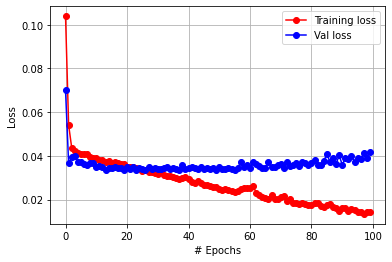

In [45]:
plt.plot(range(100), history.history['loss'], 'ro-', label="Training loss")
plt.plot(range(100), history.history['val_loss'], 'bo-', label="Val loss")
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# **model prediction on Validation Data**

1/1 [==============================] - 0s 197ms/step
RMSE: [0.19843616 0.25736351 0.15895933 0.28675697 0.13992928 0.2555672
 0.02459494 0.04798198 0.06903987 0.33755072]


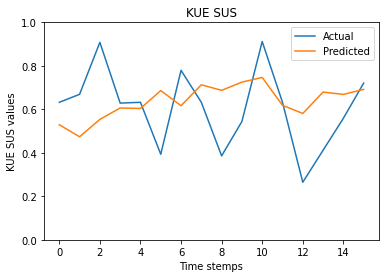

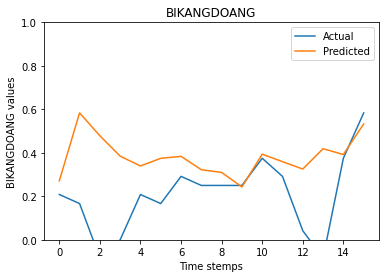

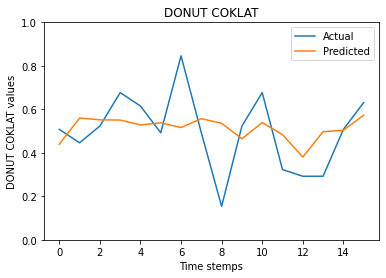

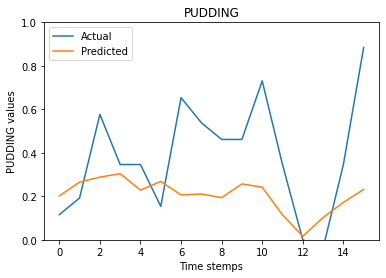

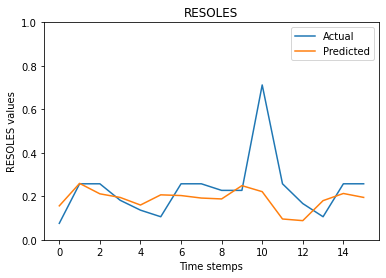

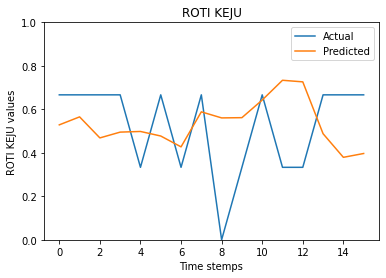

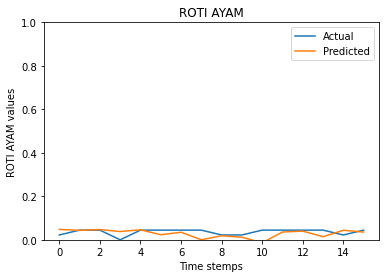

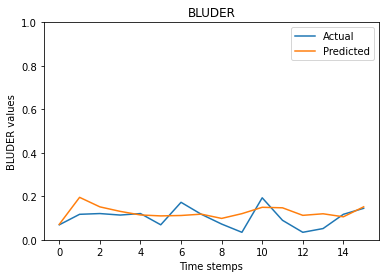

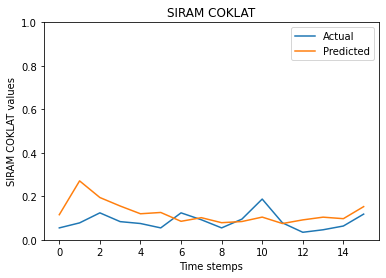

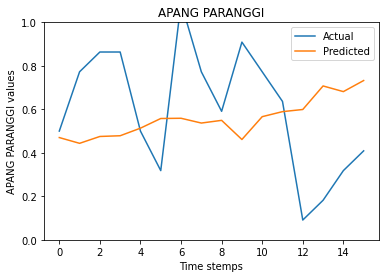

In [46]:
#  Make forecasts
# Predict the next time step for the validation data
val_pred = model.predict(val_X)


# Calculate the root mean squared error (RMSE) for each variable
rmse = np.sqrt(np.mean(np.square(val_y - val_pred), axis=0))
print(f'RMSE: {rmse}')

# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(val_y[:, i], label='Actual')
    plt.plot(val_pred[:, i], label='Predicted')
    plt.title(variable)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.ylim(0,1)
    plt.legend()
    plt.show()

# **Future Forcasting**

In [47]:
# Define the number of time steps in the input sequence
look_back = model.input_shape[1]
# Copy the last look_back days of historical data to use as a starting point for the forecast
current_input = val_X[-look_back:, :, :]
print(current_input.shape)

    
# Generate a forecast for the next days
forcasts= model.predict(current_input)

# Update the input sequence with the new forecast
current_input = np.concatenate([current_input[1:, :, :], forcasts[np.newaxis, :, :]], axis=0)

(10, 10, 10)
1/1 [==============================] - 0s 29ms/step


In [48]:
forcasts

array([[ 6.16673052e-01,  3.83829355e-01,  5.16326904e-01,
         2.06523567e-01,  2.03517199e-01,  4.27440763e-01,
         3.46922614e-02,  1.11784637e-01,  8.50579143e-02,
         5.58938503e-01],
       [ 7.12899506e-01,  3.22285831e-01,  5.57136834e-01,
         2.10762799e-01,  1.92002326e-01,  5.88490188e-01,
         1.68401588e-04,  1.17961414e-01,  1.01784453e-01,
         5.36937594e-01],
       [ 6.87317908e-01,  3.09864908e-01,  5.35883784e-01,
         1.93787232e-01,  1.87955648e-01,  5.60588419e-01,
         1.86059289e-02,  9.83798876e-02,  7.86550492e-02,
         5.49313843e-01],
       [ 7.25153923e-01,  2.43138075e-01,  4.64531124e-01,
         2.57002622e-01,  2.49066055e-01,  5.61722934e-01,
         1.17605515e-02,  1.20239779e-01,  8.40802044e-02,
         4.61294591e-01],
       [ 7.46661842e-01,  3.93828958e-01,  5.38952947e-01,
         2.41869777e-01,  2.21386403e-01,  6.42771065e-01,
        -1.37629770e-02,  1.49478644e-01,  1.04399942e-01,
         5.

In [49]:
# Get the dates for the original data
dates = data.index[-len(val_y):]
# Create a new array of dates for the forecast
forecast_dates = pd.date_range(start=dates[-1], periods=len(forcasts)+1, freq='D')[1:]

In [50]:
dates

DatetimeIndex(['2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27',
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31'],
              dtype='datetime64[ns]', name='TANGGAL', freq=None)

In [51]:
forecast_dates

DatetimeIndex(['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
               '2022-04-09', '2022-04-10'],
              dtype='datetime64[ns]', freq='D')

In [61]:
forecast_df = pd.DataFrame(forcasts, columns=['Forecast' + str(i+1) for i in range(forcasts.shape[1])])
forecast_df['Date'] = forecast_dates
forecast_df

Forecast1  Forecast2  Forecast3  Forecast4  Forecast5  Forecast6  \
0   0.616673   0.383829   0.516327   0.206524   0.203517   0.427441   
1   0.712900   0.322286   0.557137   0.210763   0.192002   0.588490   
2   0.687318   0.309865   0.535884   0.193787   0.187956   0.560588   
3   0.725154   0.243138   0.464531   0.257003   0.249066   0.561723   
4   0.746662   0.393829   0.538953   0.241870   0.221386   0.642771   
5   0.618586   0.359360   0.483771   0.114294   0.095728   0.733665   
6   0.581037   0.325466   0.380486   0.016329   0.088122   0.726388   
7   0.679394   0.418960   0.497099   0.102327   0.180129   0.487872   
8   0.668654   0.392236   0.503690   0.172229   0.213025   0.379298   
9   0.691685   0.532562   0.572795   0.231399   0.194933   0.396925   

   Forecast7  Forecast8  Forecast9  Forecast10       Date  
0   0.034692   0.111785   0.085058    0.558939 2022-04-01  
1   0.000168   0.117961   0.101784    0.536938 2022-04-02  
2   0.018606   0.098380   0.078655    0.549314 2022-04-03  
3   0.011761   0.120240   0.084080    0.461295 2022-04-04  
4  -0.013763   0.149479   0.104400    0.566267 2022-04-05  
5   0.035851   0.147153   0.074852    0.589409 2022-04-06  
6   0.039909   0.112477   0.091560    0.599281 2022-04-07  
7   0.014194   0.119678   0.104106    0.707529 2022-04-08  
8   0.043869   0.105749   0.097140    0.681526 2022-04-09  
9   0.035495   0.151620   0.152556    0.732491 2022-04-10

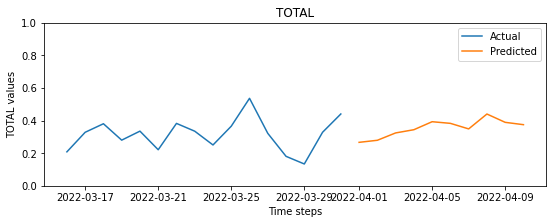

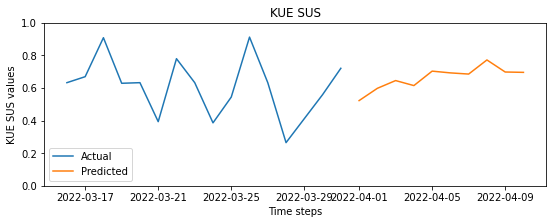

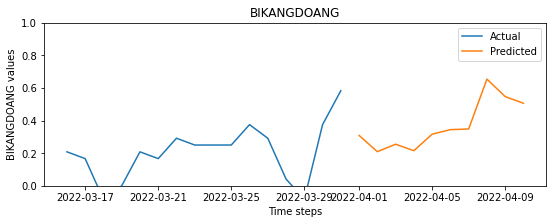

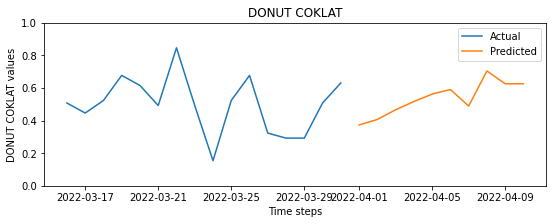

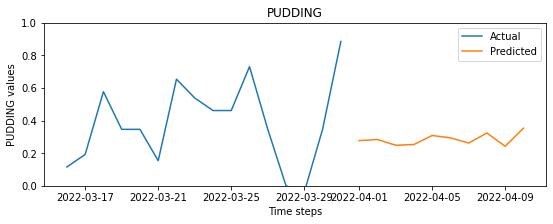

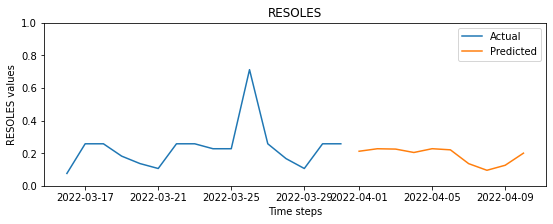

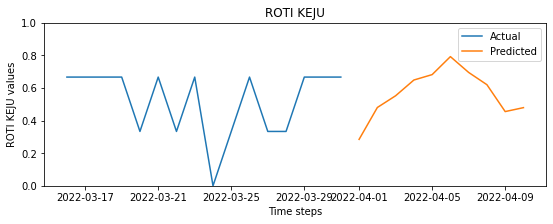

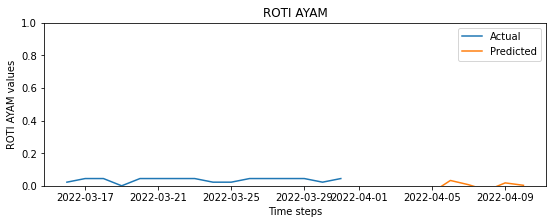

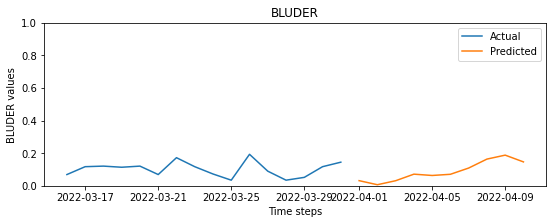

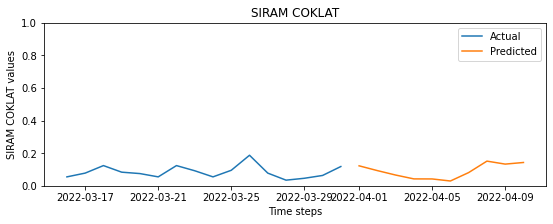

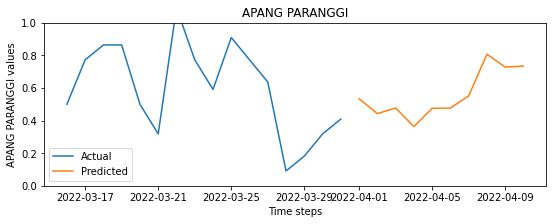

In [22]:
# Plot the predicted vs. actual values for each variable
fig_size = (9, 3)  # Set the figure size
for i, variable in enumerate(variables):
    plt.figure(figsize=fig_size)  # Set the figure size
    plt.plot(dates,val_y[:, i], label='Actual')
    plt.plot(forecast_dates,np.array(forcasts)[:, i], label='Predicted')
    plt.title(variable)
    # set y-axis limits
    plt.ylim(0, 1)
    plt.xlabel("Time steps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()
